In [1]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import random

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [3]:
PATH_TO_GRAPH = r'models/udacity_sim/24_batch/frozen_inference_graph.pb'
PATH_TO_LABELS = r'data/udacity_label_map.pbtxt'
NUM_CLASSES = 13
detection_graph = load_graph(PATH_TO_GRAPH)

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [5]:
IMAGE_SIZE = (12, 8)

SCORES
[0.99172944 0.95116776 0.15754645 0.00993685 0.00690788 0.00635628
 0.00569744 0.00480997 0.00471915 0.00470015]
CLASSES
[2. 2. 2. 1. 1. 2. 3. 2. 2. 4.]


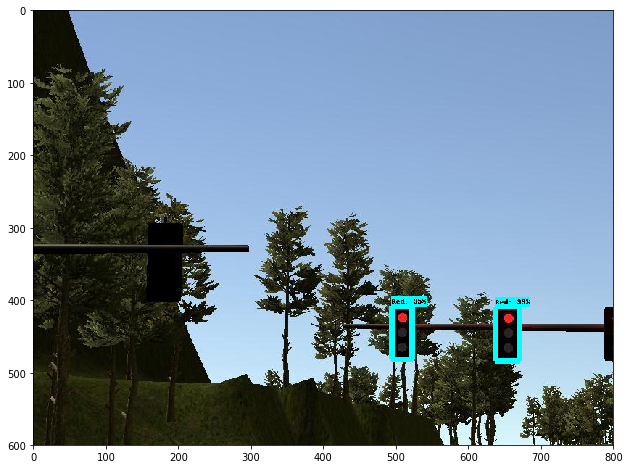

SCORES
[0.8281098  0.52618396 0.47352922 0.00717249 0.00479351 0.00425401
 0.00393957 0.00389783 0.00372615 0.00369957]
CLASSES
[2. 2. 2. 1. 1. 2. 4. 2. 1. 3.]


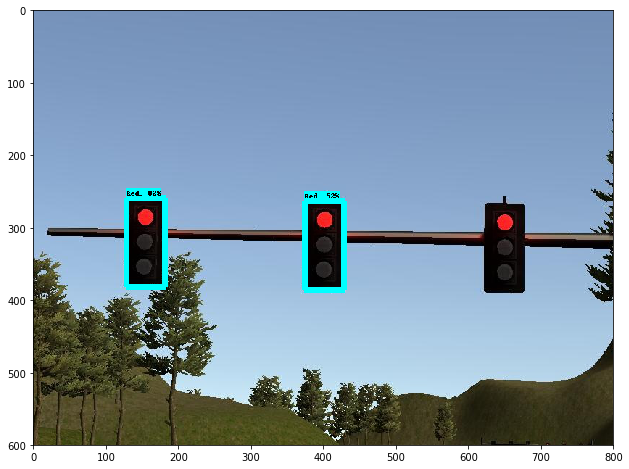

SCORES
[0.98580605 0.98276734 0.9399312  0.00597663 0.00470953 0.00464495
 0.00449273 0.00443853 0.00442755 0.0044125 ]
CLASSES
[1. 1. 1. 1. 1. 3. 1. 3. 1. 1.]


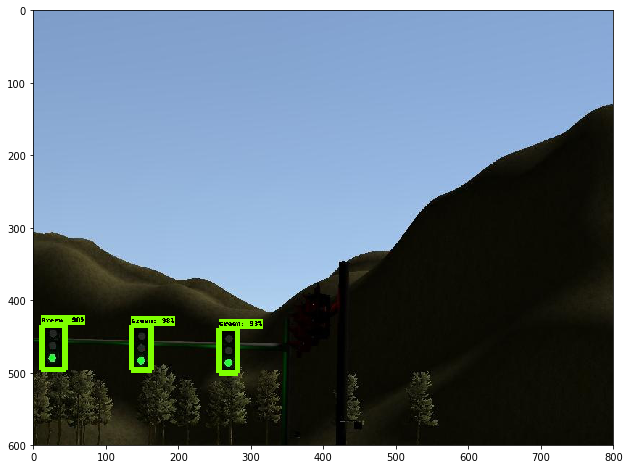

SCORES
[0.9998722  0.99958986 0.0047372  0.00393026 0.00360854 0.0035837
 0.00352494 0.0033716  0.00322223 0.00320397]
CLASSES
[1. 1. 1. 2. 3. 3. 3. 2. 1. 2.]


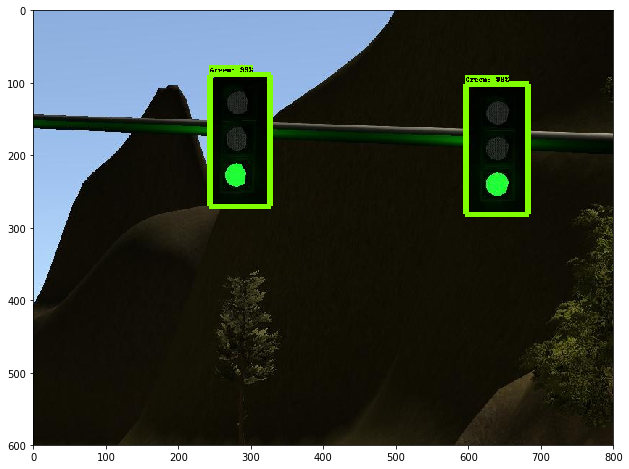

SCORES
[0.9607608  0.82229805 0.7988503  0.01134112 0.00503481 0.00474795
 0.00470512 0.00421165 0.00367761 0.0036758 ]
CLASSES
[2. 2. 2. 3. 1. 1. 2. 4. 3. 4.]


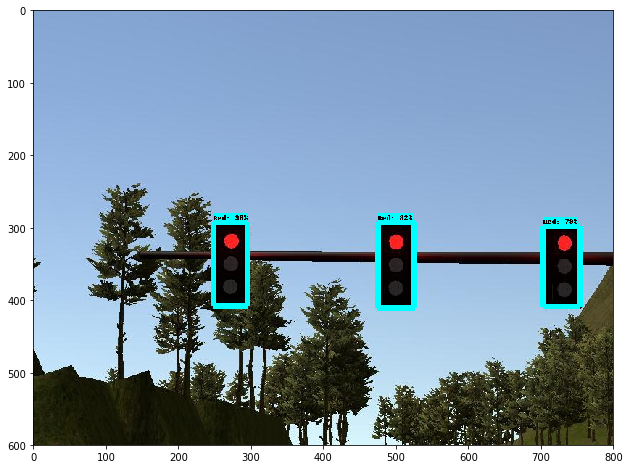

SCORES
[0.988337   0.98509884 0.73823214 0.01150094 0.01034287 0.00822598
 0.00784109 0.00671952 0.00626659 0.0055267 ]
CLASSES
[1. 1. 1. 2. 3. 2. 1. 3. 1. 2.]


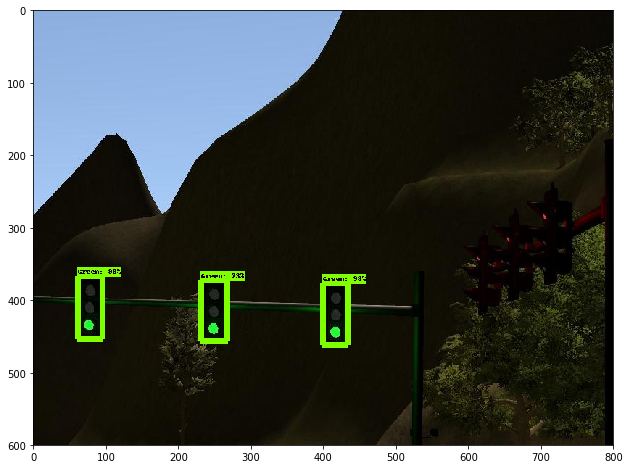

SCORES
[0.9948001  0.9869977  0.8815384  0.00237806 0.00213635 0.00208987
 0.00200076 0.00199407 0.00196597 0.00189177]
CLASSES
[1. 1. 1. 4. 1. 4. 3. 3. 2. 4.]


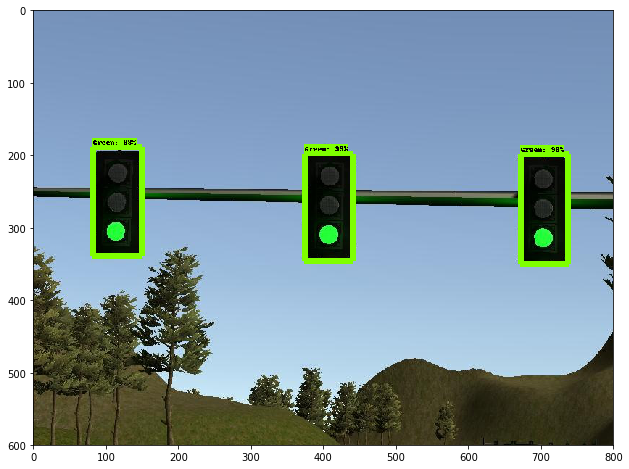

SCORES
[0.9998253  0.9990326  0.99900573 0.01373408 0.00376004 0.00250906
 0.00225492 0.00221008 0.0021208  0.00210739]
CLASSES
[2. 2. 2. 2. 2. 2. 4. 3. 4. 4.]


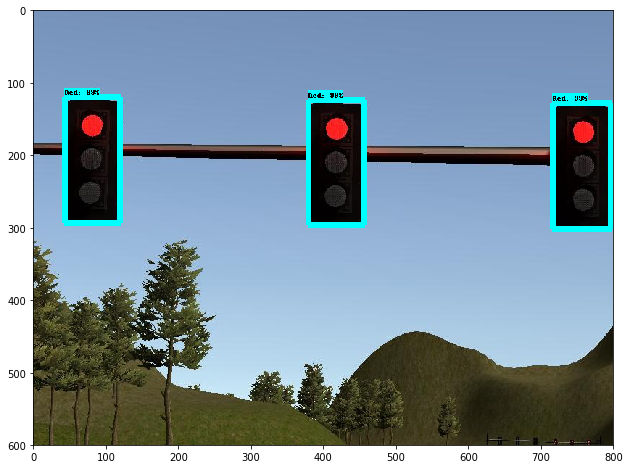

SCORES
[0.766363   0.5634697  0.47188997 0.00880967 0.00840861 0.00720433
 0.00674763 0.00669178 0.00586225 0.00554755]
CLASSES
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


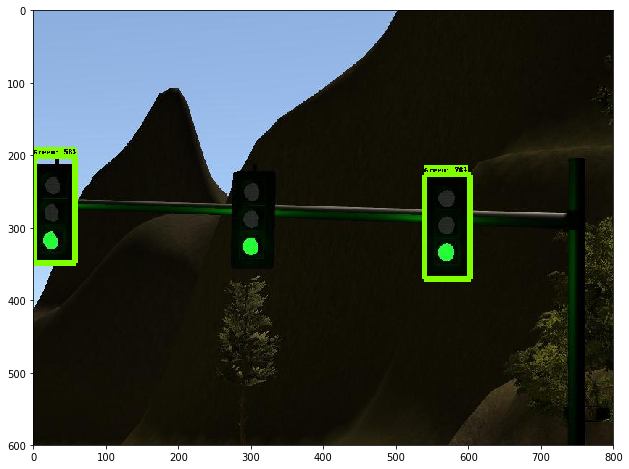

SCORES
[0.99976367 0.9987753  0.9256182  0.00501338 0.00498525 0.00372126
 0.00352639 0.00323843 0.00318858 0.00314352]
CLASSES
[2. 2. 2. 4. 2. 3. 3. 3. 3. 4.]


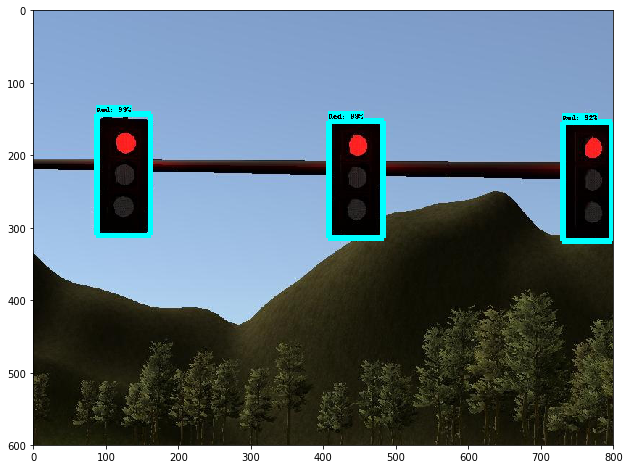

SCORES
[0.97140986 0.9483518  0.7872783  0.01039074 0.00811394 0.00526935
 0.0047471  0.00473192 0.00432266 0.00415789]
CLASSES
[1. 1. 1. 2. 1. 3. 3. 3. 2. 1.]


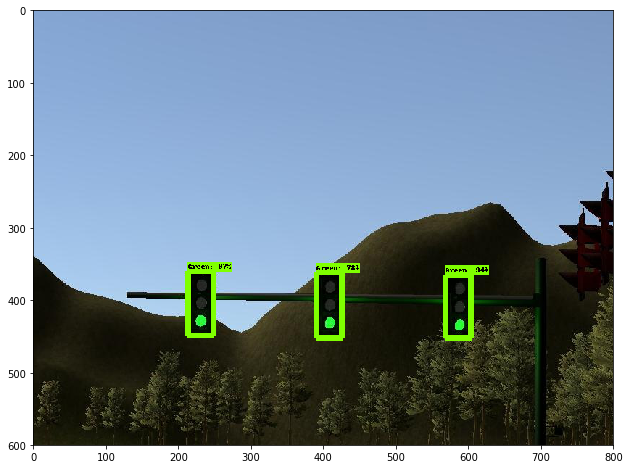

In [6]:
PATH_TO_IMGS = r'data/simulator_dataset_rgb'
subfolder = ['Green', 'Red', 'Yellow', 'Unknown']
TEST_IMGS = []
for i in subfolder:
    TEST_IMGS += glob(os.path.join(os.path.join(PATH_TO_IMGS, i), r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break